# Efficient Ingestion and Preprocessing of Large-Scale Flight Data with Apache Spark on Databricks

This notebook demonstrates a robust and modular approach to ingesting, cleaning, and validating large-scale flight data using Apache Spark. The data pre-processing follows the 6 dimensions of data quality:

### Data Quality Dimensions
![Data Quality Dimensions](https://camo.githubusercontent.com/777e7d74c5682fbd848b7b0d4a0bbaf97576c2285f65975a8c492e82e4d47e77/68747470733a2f2f7777772e7061636966696364617461696e7465677261746f72732e636f6d2f68756266732f446174612d7175616c6974792d64696d656e73696f6e732e6a7067)

**Key Aspects of Data Quality:**
- **Accuracy**: Ensuring data is correct and reliable.
- **Completeness**: No missing values or critical gaps.
- **Consistency**: Data remains uniform across different sources.
- **Timeliness**: Data is up-to-date and available when needed.
- **Validity**: Data adheres to predefined formats and constraints.
- **Uniqueness**: No duplicate records exist.
- **Integrity**: Data relationships are maintained correctly.

High-quality data is essential for analytics, decision-making, and operational efficiency.

## 1. Setting Up Environment & Downloading Data

We start by creating a data directory and fetching both the metadata and flight data files using shell commands.

In [0]:
%sh
# Clear the data directory
rm -rf /dbfs/data

In [0]:
%sh
# Create the data directory if it doesn't exist
mkdir -p /dbfs/data

# Download metadata and flight data (2004-2008)
wget "https://dataverse.harvard.edu/api/datasets/export?exporter=dataverse_json&persistentId=doi%3A10.7910/DVN/HG7NV7" -O /dbfs/data/metadata.json

wget "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/HG7NV7/CCAZGT" -O /dbfs/data/2004.csv.bz2
wget "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/HG7NV7/JTFT25" -O /dbfs/data/2005.csv.bz2
wget "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/HG7NV7/EPIFFT" -O /dbfs/data/2006.csv.bz2
wget "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/HG7NV7/2BHLWK" -O /dbfs/data/2007.csv.bz2
wget "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/HG7NV7/EIR0RA" -O /dbfs/data/2008.csv.bz2

--2025-03-23 09:11:37--  https://dataverse.harvard.edu/api/datasets/export?exporter=dataverse_json&persistentId=doi%3A10.7910/DVN/HG7NV7
Resolving dataverse.harvard.edu (dataverse.harvard.edu)... 34.198.84.59, 44.222.52.210, 52.206.100.130
Connecting to dataverse.harvard.edu (dataverse.harvard.edu)|34.198.84.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘/dbfs/data/metadata.json’

     0K .......... ........                                     233K=0.08s

2025-03-23 09:11:38 (233 KB/s) - ‘/dbfs/data/metadata.json’ saved [19357]

--2025-03-23 09:11:38--  https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/HG7NV7/CCAZGT
Resolving dataverse.harvard.edu (dataverse.harvard.edu)... 52.206.100.130, 34.198.84.59, 44.222.52.210
Connecting to dataverse.harvard.edu (dataverse.harvard.edu)|52.206.100.130|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location:

In [0]:
# List the files in /data directory
display(dbutils.fs.ls("/data"))

path name size modificationTime dbfs:/data/2004.csv.bz2 2004.csv.bz2 110825331 1742721105000 dbfs:/data/2005.csv.bz2 2005.csv.bz2 112450321 1742721113000 dbfs:/data/2006.csv.bz2 2006.csv.bz2 115019195 1742721120000 dbfs:/data/2007.csv.bz2 2007.csv.bz2 121249243 1742721128000 dbfs:/data/2008.csv.bz2 2008.csv.bz2 39277452 1742721131000 dbfs:/data/metadata.json metadata.json 19357 1742721098000

In [0]:
%sh
# Unzip the flight data files
for file in /dbfs/data/*.bz2; do 
    if [[ -f $file ]]; then 
        bzip2 -d "$file" && echo "Unzipped: $file"; 
    else 
        echo "No .bz2 files found in the directory."; 
    fi 
done 

Unzipped: /dbfs/data/2004.csv.bz2
Unzipped: /dbfs/data/2005.csv.bz2
Unzipped: /dbfs/data/2006.csv.bz2
Unzipped: /dbfs/data/2007.csv.bz2
Unzipped: /dbfs/data/2008.csv.bz2


In [0]:
display(dbutils.fs.ls("/data"))

path name size modificationTime dbfs:/data/2004.csv 2004.csv 669879113 1742721181000 dbfs:/data/2005.csv 2005.csv 671027265 1742721225000 dbfs:/data/2006.csv 2006.csv 672068096 1742721268000 dbfs:/data/2007.csv 2007.csv 702878193 1742721314000 dbfs:/data/2008.csv 2008.csv 234052199 1742721329000 dbfs:/data/metadata.json metadata.json 19357 1742721098000

## 2. Data Ingestion and Initial Exploration

Here we load the metadata and flight CSV files into Spark DataFrames and define a schema for the flight data.

In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
import matplotlib.pyplot as plt

# Load metadata for reference
flights_metadata = spark.read.json("/data/metadata.json")
display(flights_metadata)

authority datasetVersion id identifier persistentUrl protocol publicationDate publisher storageIdentifier 10.7910 List(2008, "Data Expo 2009: Airline on time data", https://doi.org/10.7910/DVN/HG7NV7, Harvard Dataverse, V1, 2008-10-06T19:04:55Z, 60715, doi:10.7910/DVN/HG7NV7, false, List(List(List(2. Data), List(List(MD5, e5cd6860f3ae620b6ccc1d5a24c9734e), application/octet-stream, 2008-10-07, , 1987.csv.bz2, 12652442, 1375005, e5cd6860f3ae620b6ccc1d5a24c9734e, doi:10.7910/DVN/HG7NV7/IXITH2, https://doi.org/10.7910/DVN/HG7NV7/IXITH2, -1, s3://dvn-cloud:17070), 62280, , 1987.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 0be4b20eeb0531c7e328461ce42d9a9c), application/octet-stream, 2008-10-07, , 1988.csv.bz2, 49499025, 1375004, 0be4b20eeb0531c7e328461ce42d9a9c, doi:10.7910/DVN/HG7NV7/TUYWU3, https://doi.org/10.7910/DVN/HG7NV7/TUYWU3, -1, s3://dvn-cloud:17069), 62280, , 1988.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 6141c0c611b92fdf5fdad32a4061c7fc), application/octet-stream, 2008-10-07, , 1989.csv.bz2, 49202298, 1375003, 6141c0c611b92fdf5fdad32a4061c7fc, doi:10.7910/DVN/HG7NV7/T7EP3M, https://doi.org/10.7910/DVN/HG7NV7/T7EP3M, -1, s3://dvn-cloud:17068), 62280, , 1989.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, cbdfb96084323b65595c47f5589e1392), application/octet-stream, 2008-10-07, , 1990.csv.bz2, 52041322, 1375002, cbdfb96084323b65595c47f5589e1392, doi:10.7910/DVN/HG7NV7/QJKL3I, https://doi.org/10.7910/DVN/HG7NV7/QJKL3I, -1, s3://dvn-cloud:17067), 62280, , 1990.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 854cf258d42b6663f373a49986a98cff), application/octet-stream, 2008-10-07, , 1991.csv.bz2, 49877448, 1375001, 854cf258d42b6663f373a49986a98cff, doi:10.7910/DVN/HG7NV7/EJ4WJO, https://doi.org/10.7910/DVN/HG7NV7/EJ4WJO, -1, s3://dvn-cloud:17064), 62280, , 1991.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 2d744403ee4280d4044c494db17edc98), application/octet-stream, 2008-10-07, , 1992.csv.bz2, 50040946, 1375000, 2d744403ee4280d4044c494db17edc98, doi:10.7910/DVN/HG7NV7/PLPDQO, https://doi.org/10.7910/DVN/HG7NV7/PLPDQO, -1, s3://dvn-cloud:17062), 62280, , 1992.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, deb91bafad00b8f40609553349539545), application/octet-stream, 2008-10-07, , 1993.csv.bz2, 50111774, 1374999, deb91bafad00b8f40609553349539545, doi:10.7910/DVN/HG7NV7/IOU9DX, https://doi.org/10.7910/DVN/HG7NV7/IOU9DX, -1, s3://dvn-cloud:17060), 62280, , 1993.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, d2ca7209c75ee572f9033d620041327c), application/octet-stream, 2008-10-07, , 1994.csv.bz2, 51123887, 1374998, d2ca7209c75ee572f9033d620041327c, doi:10.7910/DVN/HG7NV7/BH5P0X, https://doi.org/10.7910/DVN/HG7NV7/BH5P0X, -1, s3://dvn-cloud:17057), 62280, , 1994.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 949dea36c5cfde671325ba52ff86cb2f), application/octet-stream, 2008-10-07, , 1995.csv.bz2, 74881752, 1374997, 949dea36c5cfde671325ba52ff86cb2f, doi:10.7910/DVN/HG7NV7/ZLTTDC, https://doi.org/10.7910/DVN/HG7NV7/ZLTTDC, -1, s3://dvn-cloud:17055), 62280, , 1995.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 7af30b0699a490b759fa9d39ed507174), application/octet-stream, 2008-10-07, , 1996.csv.bz2, 75887707, 1374996, 7af30b0699a490b759fa9d39ed507174, doi:10.7910/DVN/HG7NV7/3KDWWL, https://doi.org/10.7910/DVN/HG7NV7/3KDWWL, -1, s3://dvn-cloud:17054), 62280, , 1996.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 41bd1e5e7916ec6d6722ec9002d526ca), application/octet-stream, 2008-10-07, , 1997.csv.bz2, 76705687, 1374995, 41bd1e5e7916ec6d6722ec9002d526ca, doi:10.7910/DVN/HG7NV7/RUGDRW, https://doi.org/10.7910/DVN/HG7NV7/RUGDRW, -1, s3://dvn-cloud:17053), 62280, , 1997.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 442ce082e94021d3def5311ac75b9066), application/octet-stream, 2008-10-07, , 1998.csv.bz2, 76683506, 1374994, 442ce082e94021d3def5311ac75b9066, doi:10.7910/DVN/HG7NV7/H07RX8, https://doi.org/10.7910/DVN/HG7NV7/H07RX8, -1, s3://dvn-cloud:17052), 6

In [0]:
# Define schema for flight data
schema = StructType([
    StructField('Year', IntegerType()),
    StructField('Month', IntegerType()),
    StructField('DayofMonth', IntegerType()),
    StructField('DayOfWeek', IntegerType()),
    StructField('DepTime', IntegerType()),
    StructField('CRSDepTime', IntegerType()),
    StructField('ArrTime', IntegerType()),
    StructField('CRSArrTime', IntegerType()),
    StructField('UniqueCarrier', StringType()),
    StructField('FlightNum', IntegerType()),
    StructField('TailNum', IntegerType()),
    StructField('ActualElapsedTime', IntegerType()),
    StructField('CRSElapsedTime', IntegerType()),
    StructField('AirTime', IntegerType()),
    StructField('ArrDelay', IntegerType()),
    StructField('DepDelay', IntegerType()),
    StructField('Origin', StringType()),
    StructField('Dest', StringType()),
    StructField('Distance', IntegerType()),
    StructField('TaxiIn', IntegerType()),
    StructField('TaxiOut', IntegerType()),
    StructField('Cancelled', IntegerType()),
    StructField('CancellationCode', StringType()),
    StructField('Diverted', IntegerType()),
    StructField('CarrierDelay', IntegerType()),
    StructField('WeatherDelay', IntegerType()),
    StructField('NASDelay', IntegerType()),
    StructField('SecurityDelay', IntegerType()),
    StructField('LateAircraftDelay', IntegerType())
])

In [0]:
# Read one of the yearly files to preview the data (e.g., 2004)
flights_2004 = spark.read.csv("/data/2004.csv", header=True, schema=schema)
flights_2004.limit(5).display()

Year Month DayofMonth DayOfWeek DepTime CRSDepTime ArrTime CRSArrTime UniqueCarrier FlightNum TailNum ActualElapsedTime CRSElapsedTime AirTime ArrDelay DepDelay Origin Dest Distance TaxiIn TaxiOut Cancelled CancellationCode Diverted CarrierDelay WeatherDelay NASDelay SecurityDelay LateAircraftDelay 2004 1 12 1 623 630 901 915 UA 462 null 98 105 80 -14 -7 ORD CLT 599 7 11 0 null 0 0 0 0 0 0 2004 1 13 2 621 630 911 915 UA 462 null 110 105 78 -4 -9 ORD CLT 599 16 16 0 null 0 0 0 0 0 0 2004 1 14 3 633 630 920 915 UA 462 null 107 105 88 5 3 ORD CLT 599 4 15 0 null 0 0 0 0 0 0 2004 1 15 4 627 630 859 915 UA 462 null 92 105 78 -16 -3 ORD CLT 599 4 10 0 null 0 0 0 0 0 0 2004 1 16 5 635 630 918 915 UA 462 null 103 105 87 3 5 ORD CLT 599 3 13 0 null 0 0 0 0 0 0

In [0]:
flights_2004.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: integer (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true

In [0]:
flights_2004.describe().display()

summary Year Month DayofMonth DayOfWeek DepTime CRSDepTime ArrTime CRSArrTime UniqueCarrier FlightNum TailNum ActualElapsedTime CRSElapsedTime AirTime ArrDelay DepDelay Origin Dest Distance TaxiIn TaxiOut Cancelled CancellationCode Diverted CarrierDelay WeatherDelay NASDelay SecurityDelay LateAircraftDelay count 7129270 7129270 7129270 7129270 7001513 7129270 6987729 7129270 7129270 7129270 81490 6987729 7129270 6987729 6987729 7001513 7129270 7129270 7129270 7129270 7129270 7129270 127764 7129270 7129270 7129270 7129270 7129270 7129270 mean 2004.0 6.549743101327345 15.763779461291268 3.9436025006767874 1346.5570246031107 1340.7918579321586 1496.6380706807606 1503.6623596805844 null 2091.4139651044215 0.0 123.38259969726931 124.45167064790645 102.21875705254168 6.508066211497327 7.8923142755001665 null null 713.5999591823567 7.84662553108523 15.722683248074487 0.01792006755249836 null 0.0019334377853553028 2.641655176476694 0.7065884725925656 3.4326591642622595 0.025138478413638424 3.4458253089025943 stddev 0.0 3.4373915436651594 8.801830406243052 1.9862549788338044 473.64549130742006 462.35992148220305 495.01935283744683 476.8855983860032 null 1955.0002290316922 0.0 70.62331665898753 69.60259571477252 84.97219453470187 33.32947743944376 29.896233282530034 null null 571.8567520088155 46.62986271530594 15.295745428274635 0.13266100105140052 null 0.043928349324307045 16.350258268959262 8.630164340185287 14.808227348545948 1.2451684510624135 16.83761119173033 min 2004 1 1 1 1 0 1 0 AA 1 0 -710 -64 -3818 -1302 -1197 ABE ABE 6 0 0 0 A 0 0 0 -25 0 0 max 2004 12 31 7 2750 2359 2955 2400 XE 9912 0 1744 1374 1936 1879 1882 YUM YUM 4962 1473 3905 1 D 1 1879 1230 1380 533 1344

## 3. Data Consolidation and Cleaning

In this section we load all the yearly files and consolidate them into a single DataFrame. We also show an example of nullifying columns that may be problematic and later drop columns with no data.

In [0]:
# Load other years
flights_2005 = spark.read.csv("/data/2005.csv", header=True, schema=schema)
flights_2006 = spark.read.csv("/data/2006.csv", header=True, schema=schema)
flights_2007 = spark.read.csv("/data/2007.csv", header=True, schema=schema)
flights_2008 = spark.read.csv("/data/2008.csv", header=True, schema=schema)

# Combine data if needed. Here we use 2008 for demonstration.
df_flights = flights_2004.union(flights_2005).union(flights_2006).union(flights_2007).union(flights_2008)
df_flights = flights_2008

df_flights.limit(5).display()

Year Month DayofMonth DayOfWeek DepTime CRSDepTime ArrTime CRSArrTime UniqueCarrier FlightNum TailNum ActualElapsedTime CRSElapsedTime AirTime ArrDelay DepDelay Origin Dest Distance TaxiIn TaxiOut Cancelled CancellationCode Diverted CarrierDelay WeatherDelay NASDelay SecurityDelay LateAircraftDelay 2008 1 3 4 1343 1325 1451 1435 WN 588 null 68 70 55 16 18 HOU LIT 393 4 9 0 null 0 16 0 0 0 0 2008 1 3 4 1125 1120 1247 1245 WN 1343 null 82 85 71 2 5 HOU MAF 441 3 8 0 null 0 null null null null null 2008 1 3 4 2009 2015 2136 2140 WN 3841 null 87 85 71 -4 -6 HOU MAF 441 2 14 0 null 0 null null null null null 2008 1 3 4 903 855 1203 1205 WN 3 null 120 130 108 -2 8 HOU MCO 848 5 7 0 null 0 null null null null null 2008 1 3 4 1423 1400 1726 1710 WN 25 null 123 130 107 16 23 HOU MCO 848 6 10 0 null 0 16 0 0 0 0

### 3.1 Data Completeness and Column Validation

We check for columns with no data and drop them. We also evaluate missing values and then drop any rows with nulls.

In [0]:
# Calculate non-null counts for each column
non_null_counts_df = df_flights.agg(*[
    sum(col(column).isNotNull().cast("int")).alias(column) for column in df_flights.columns
])
non_null_counts = non_null_counts_df.first().asDict()
columns_to_drop = [col_name for col_name, count in non_null_counts.items() if count == 0]

# Drop columns with no data and log the dropped columns
main_df = df_flights.drop(*columns_to_drop)
for col_name in columns_to_drop:
    print(f"Dropped column: {col_name}")

Dropped column: TailNum


In [0]:
display(main_df.describe())

summary Year Month DayofMonth DayOfWeek DepTime CRSDepTime ArrTime CRSArrTime UniqueCarrier FlightNum ActualElapsedTime CRSElapsedTime AirTime ArrDelay DepDelay Origin Dest Distance TaxiIn TaxiOut Cancelled CancellationCode Diverted CarrierDelay WeatherDelay NASDelay SecurityDelay LateAircraftDelay count 2389217 2389217 2389217 2389217 2324775 2389217 2319121 2389217 2389217 2389217 2319121 2388810 2319121 2319121 2324775 2389217 2389217 2389217 2319121 2324775 2389217 64442 2389217 584583 584583 584583 584583 584583 mean 2008.0 2.5050093817346855 15.66385640149053 3.909625203570877 1340.0181824047488 1329.9923137998767 1485.83506595818 1496.7439889302645 null 2213.8879804555218 128.6188827577345 129.37755074702466 105.10161910482464 10.27356916693868 11.436358787409533 null null 726.158911057472 6.839862171917722 16.685844006409223 0.026972016355148988 null 0.0023664656663668474 15.752957236183741 2.9382431579433543 16.1584616726795 0.080459062271739 20.976709894061237 stddev 0.0 1.1214926484930106 8.750405152891235 1.9804305935434372 480.27171756729274 465.78327521775986 508.1294784988582 484.5237588747331 null 1951.3921009506232 70.2530332818593 69.48245857095564 67.66801412821346 39.63428984150192 36.53229365595569 null null 557.1762606457419 4.846435348258893 11.02904905884216 0.1620016594774992 null 0.04858874864359787 40.035486759239284 19.16666182034626 30.5341665217005 1.7425788428981344 38.617153773442794 min 2008 1 1 1 1 0 1 1 9E 1 14 -25 0 -91 -92 ABE ABE 17 0 0 0 A 0 0 0 0 0 0 max 2008 4 31 7 2400 2359 2400 2400 YV 9741 905 1435 886 2461 2467 YUM YUM 4962 213 383 1 D 1 2436 1148 1357 392 1254

In [0]:
# Compute null counts per column (as both absolute and percentage)
total_count = main_df.count()
null_counts_df = main_df.agg(*[
    sum(col(c).isNull().cast("int")).alias(c) for c in main_df.columns
])
null_counts = null_counts_df.first().asDict()
with_nulls = [
    {col_name: [null_count, null_count / total_count]} 
    for col_name, null_count in null_counts.items() if null_count > 0
]
print("Columns with null counts (absolute and ratio):", with_nulls)

Columns with null counts (absolute and ratio): [{'DepTime': [64442, 0.026972016355148988]}, {'ArrTime': [70096, 0.029338482021515837]}, {'ActualElapsedTime': [70096, 0.029338482021515837]}, {'CRSElapsedTime': [407, 0.00017034869582796373]}, {'AirTime': [70096, 0.029338482021515837]}, {'ArrDelay': [70096, 0.029338482021515837]}, {'DepDelay': [64442, 0.026972016355148988]}, {'TaxiIn': [70096, 0.029338482021515837]}, {'TaxiOut': [64442, 0.026972016355148988]}, {'CancellationCode': [2324775, 0.973027983644851]}, {'CarrierDelay': [1804634, 0.7553244431125343]}, {'WeatherDelay': [1804634, 0.7553244431125343]}, {'NASDelay': [1804634, 0.7553244431125343]}, {'SecurityDelay': [1804634, 0.7553244431125343]}, {'LateAircraftDelay': [1804634, 0.7553244431125343]}]


## 4. Data Accuracy and Visualization

We generate histograms for numerical (integer) columns to check their distributions.

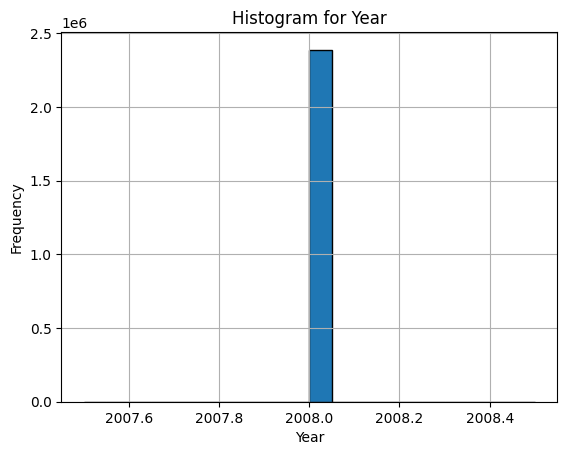

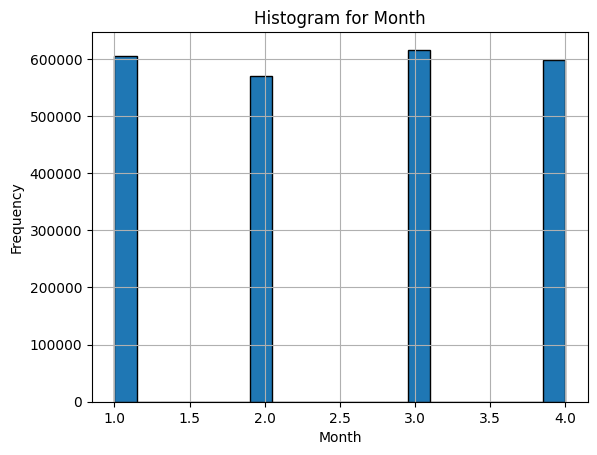

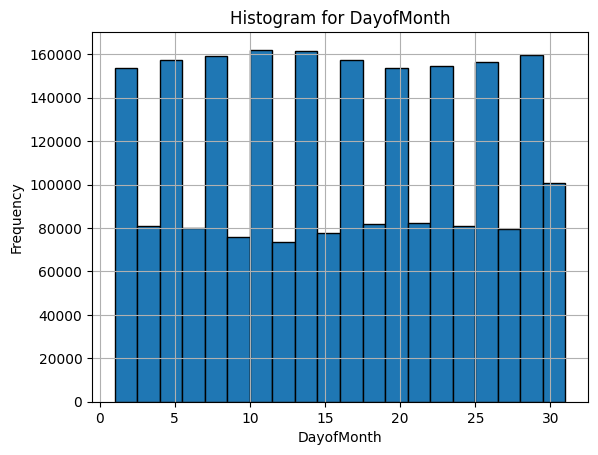

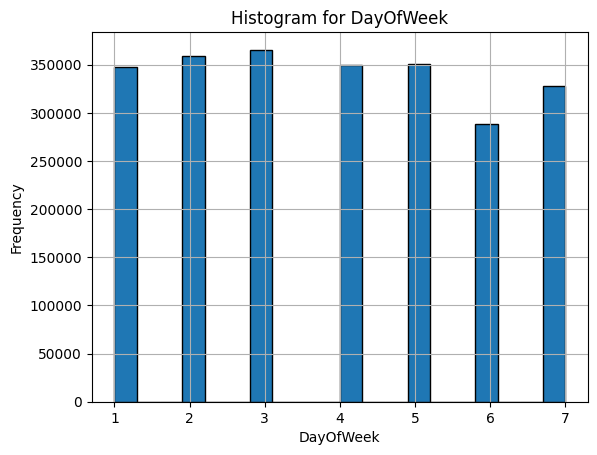

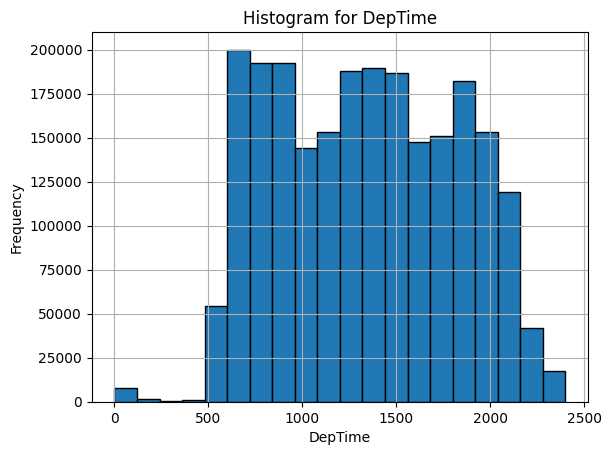

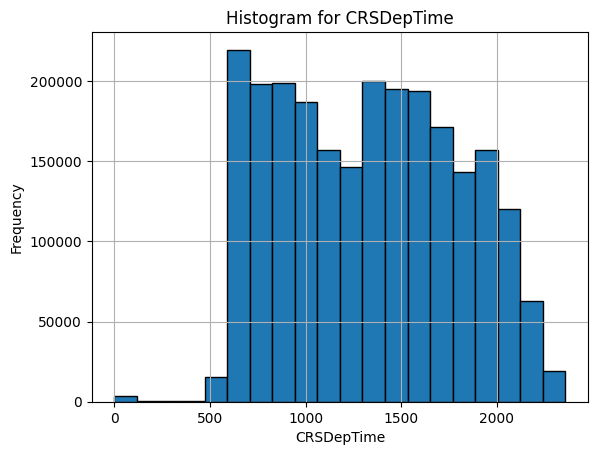

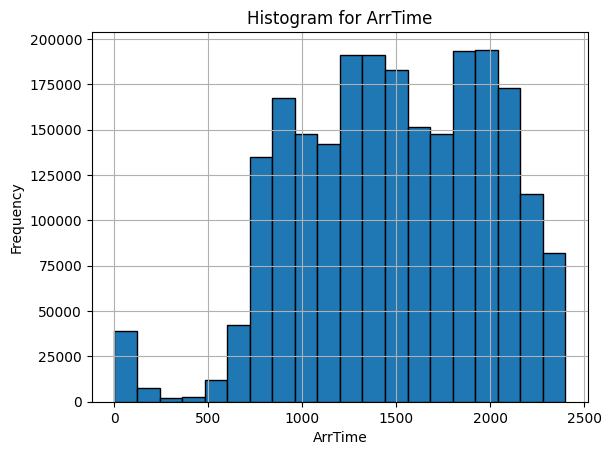

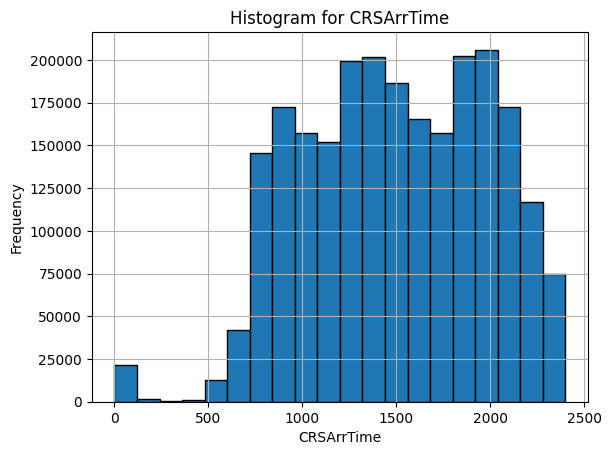

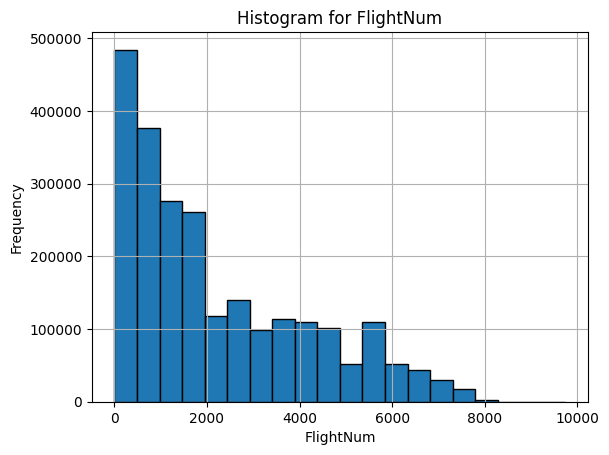

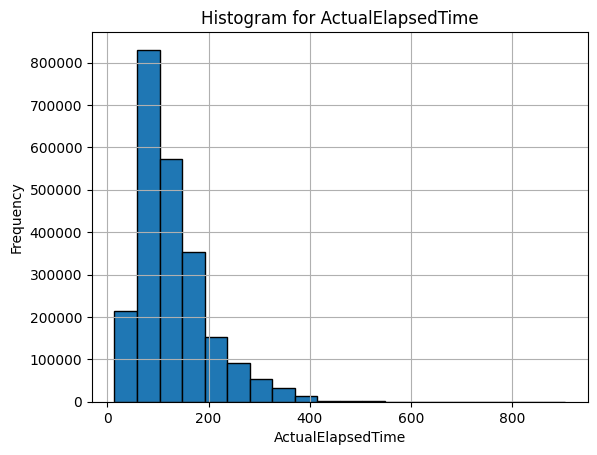

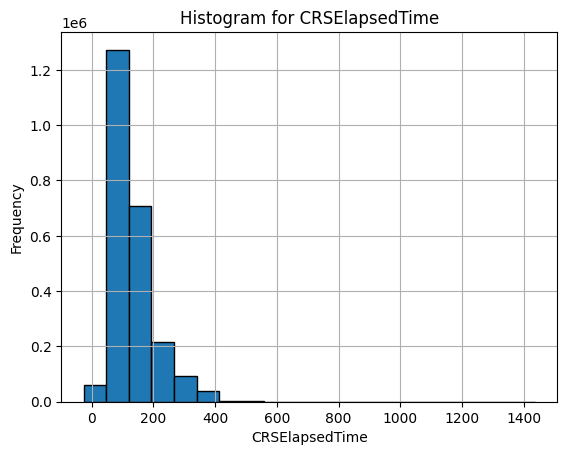

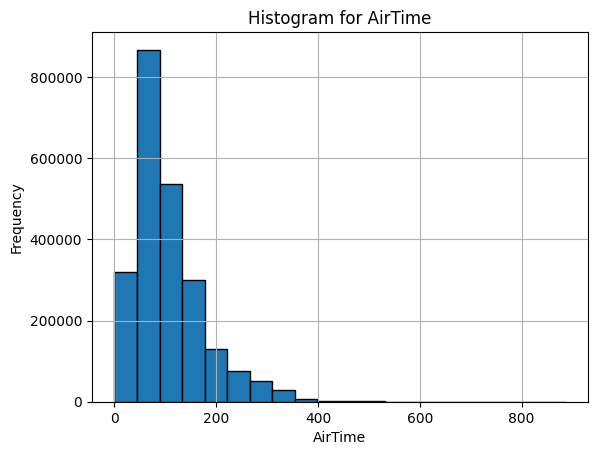

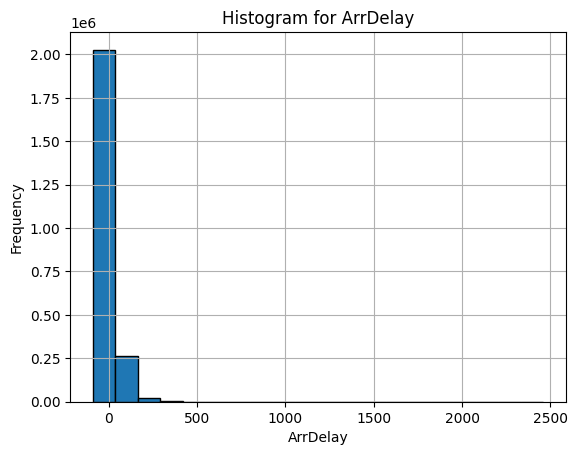

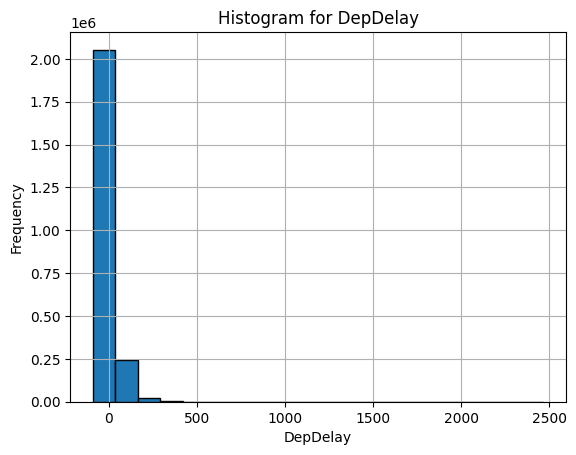

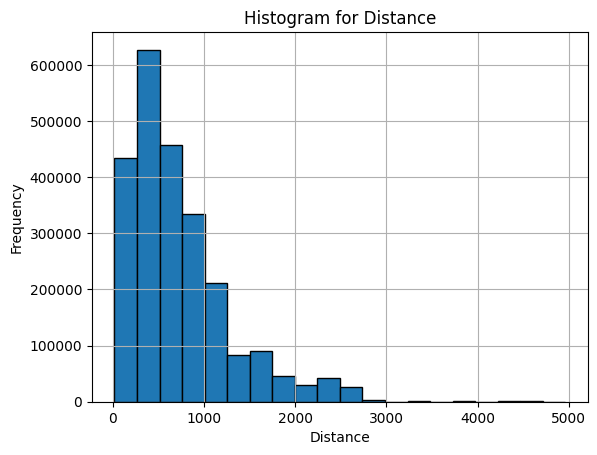

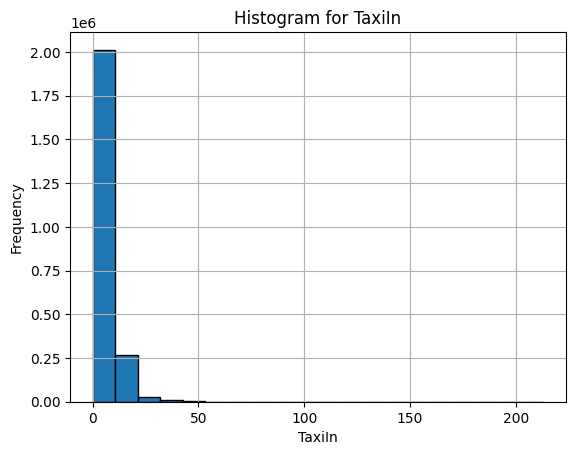

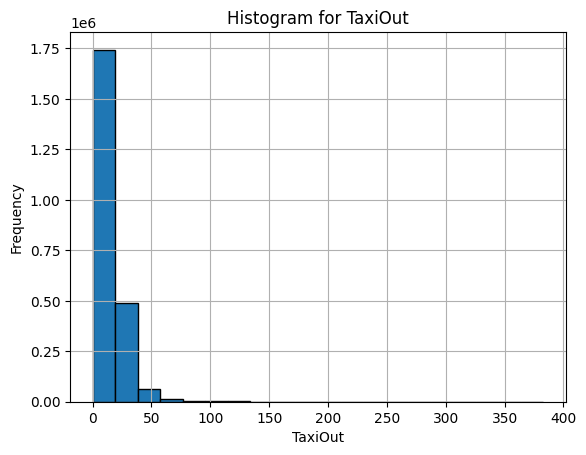

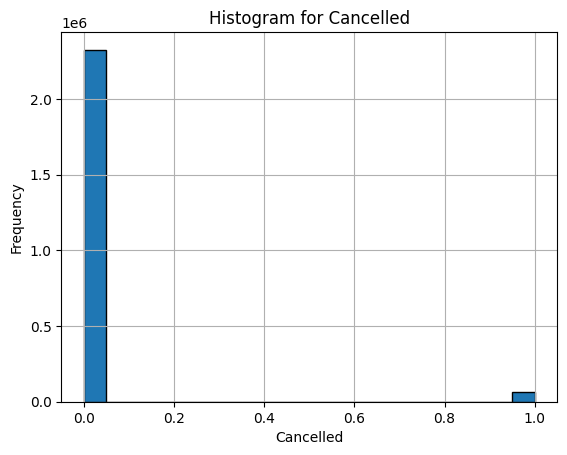

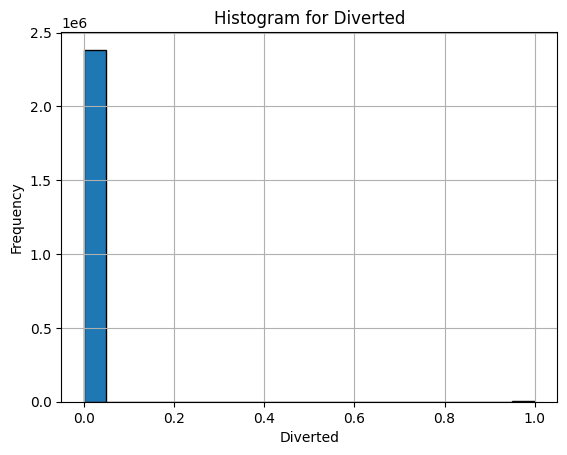

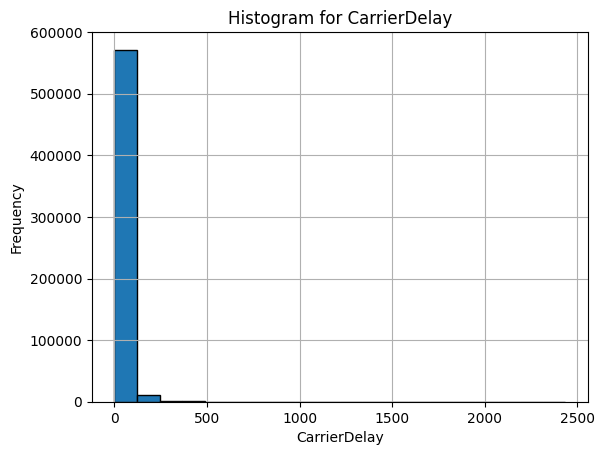

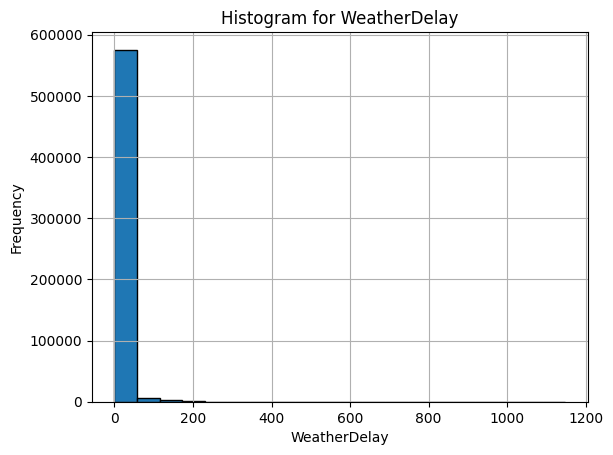

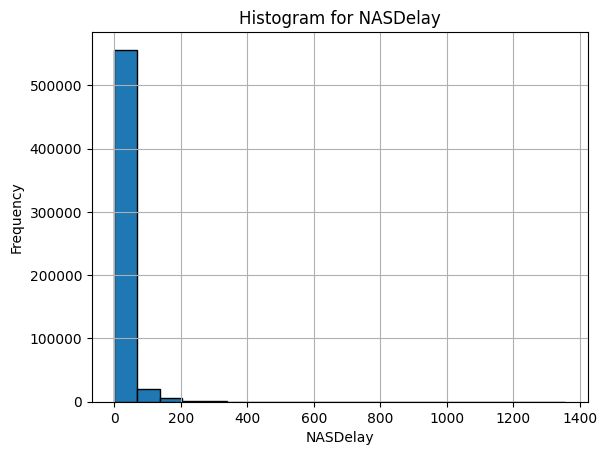

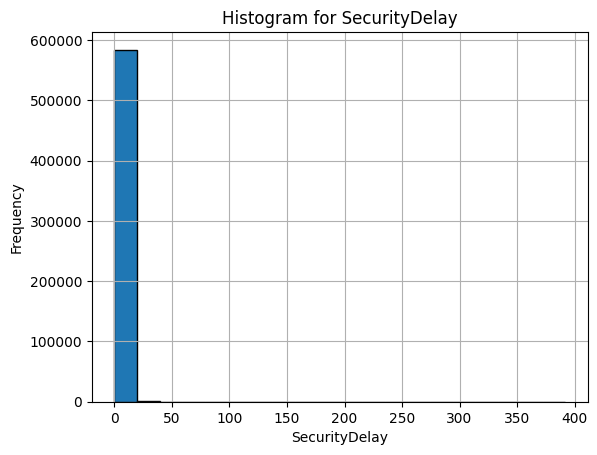

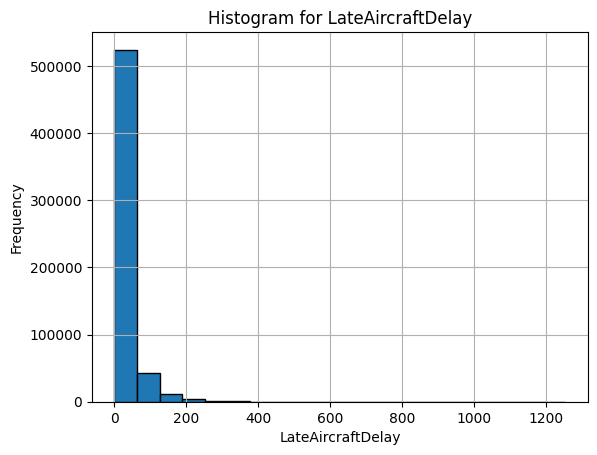

In [0]:
# Plot histograms for integer columns
from pyspark.sql.types import IntegerType

for column in main_df.columns:
    if isinstance(main_df.schema[column].dataType, IntegerType):
        pd_df = main_df.select(col(column)).toPandas()
        if not pd_df.empty:
            pd_df.hist(column=column, bins=20, edgecolor='black')
            plt.title(f"Histogram for {column}")
            plt.xlabel(column)
            plt.ylabel("Frequency")
            plt.show()

## 5. Data Consistency Checks

We analyze string columns to check that categorical data remains consistent.

In [0]:
string_columns = [c for c, t in main_df.dtypes if t == "string"]
print("String columns in the data:", string_columns)

for column in string_columns:
    main_df.groupBy(column).count().select(column, "count").orderBy(column).show()

String columns in the data: ['UniqueCarrier', 'Origin', 'Dest', 'CancellationCode']
+-------------+------+
|UniqueCarrier| count|
+-------------+------+
|           9E| 88359|
|           AA|204519|
|           AQ|  7800|
|           AS| 49885|
|           B6| 67478|
|           CO|102702|
|           DL|151409|
|           EV| 92383|
|           F9| 30680|
|           FL| 86856|
|           HA| 18385|
|           MQ|167860|
|           NW|122799|
|           OH| 71934|
|           OO|195184|
|           UA|154036|
|           US|153539|
|           WN|398966|
|           XE|138757|
|           YV| 85686|
+-------------+------+

+------+------+
|Origin| count|
+------+------+
|   ABE|  1609|
|   ABI|   882|
|   ABQ| 13569|
|   ABY|   418|
|   ACT|   751|
|   ACV|  1163|
|   ACY|   116|
|   ADK|    34|
|   ADQ|   242|
|   AEX|   804|
|   AGS|   729|
|   AKN|     2|
|   ALB|  4677|
|   ALO|   104|
|   AMA|  2483|
|   ANC|  5456|
|   ASE|  2532|
|   ATL|137014|
|   ATW|  1856|
|   AUS| 17

## 6. Data Uniqueness

We check for duplicate rows and duplicates based on a compound primary key. For the compound key, we generate a timestamp from the departure time.

**Compound Primary Key Fields:**
- Origin
- UniqueCarrier
- FlightNum
- DepTime_Timestamp

In [0]:
# Count identical rows
duplicate_count = main_df.groupBy(main_df.columns).count().where(col("count") > 1).count()
print(f"Number of identical duplicate rows: {duplicate_count}")

# Remove identical duplicate rows
unique_rows = main_df.dropDuplicates()
duplicate_after_drop = unique_rows.groupBy(unique_rows.columns).count().where(col("count") > 1).count()
print(f"Duplicate rows after dropDuplicates: {duplicate_after_drop}")

# Create departure timestamp and check duplicates based on the compound key
primary_key_fields = ["Origin", "UniqueCarrier", "FlightNum", "DepTime_Timestamp"]

unique_rows.createOrReplaceTempView("unique_rows")
unique_rows = spark.sql("""
SELECT *,
  CASE 
    WHEN substring(cast(DepTime AS string), 1, 2) = '24' THEN '00'
    WHEN length(cast(DepTime AS string)) < 3 THEN '00'
    WHEN length(cast(DepTime AS string)) = 3 THEN substring(cast(DepTime AS string), 1, 1)
    ELSE substring(cast(DepTime AS string), 1, 2)
  END AS DepTime_Hour,
  
  right(cast(DepTime AS string), 2) AS DepTime_Min,
  
  to_timestamp(
    concat(
      cast(Year AS string), '-', 
      lpad(cast(Month AS string), 2, '0'), '-', 
      lpad(cast(DayofMonth AS string), 2, '0'), ' ',
      lpad(
        CASE 
          WHEN substring(cast(DepTime AS string), 1, 2) = '24' THEN '00'
          WHEN length(cast(DepTime AS string)) < 3 THEN '00'
          WHEN length(cast(DepTime AS string)) = 3 THEN substring(cast(DepTime AS string), 1, 1)
          ELSE substring(cast(DepTime AS string), 1, 2)
        END, 2, '0'
      ),
      ':',
      lpad(right(cast(DepTime AS string), 2), 2, '0')
    ),
    'yyyy-MM-dd HH:mm'
  ) AS DepTime_Timestamp
FROM unique_rows
""")

compound_duplicates = unique_rows.groupBy(primary_key_fields).count().where(col("count") > 1).count()
print(f"Duplicate rows based on the compound primary key: {compound_duplicates}")

Number of identical duplicate rows: 4
Duplicate rows after dropDuplicates: 0
Duplicate rows based on the compound primary key: 12245


## 7. Data Validity Checks

We perform several validity checks to ensure that numerical values fall within expected ranges.

**Checks Include:**
- Year < current year
- Month between 1 and 12
- DayofMonth between 1 and 31
- DayOfWeek between 1 and 7
- Time fields between 1 and 2400
- FlightNum and Distance greater than 0

In [0]:
# Current year for validation
current_year = year(current_date())

def check_validity(df, column, condition, message):
    failures = df.filter(~condition)
    print(f"{message} Failures:")
    if failures.count() > 0:
        failures.show()
    else:
        print("All rows meet the validity criteria\n")

# Check Year
check_validity(unique_rows, "Year", col("Year") < current_year, "Year Check")

# Check Month (1-12)
check_validity(unique_rows, "Month", (col("Month") >= 1) & (col("Month") <= 12), "Month Check")

# Check DayofMonth (1-31)
check_validity(unique_rows, "DayofMonth", (col("DayofMonth") >= 1) & (col("DayofMonth") <= 31), "DayofMonth Check")

# Check DayOfWeek (1-7)
check_validity(unique_rows, "DayOfWeek", (col("DayOfWeek") >= 1) & (col("DayOfWeek") <= 7), "DayOfWeek Check")

# Check DepTime (1-2400)
check_validity(unique_rows, "DepTime", (col("DepTime") >= 1) & (col("DepTime") <= 2400), "DepTime Check")

# Check CRSDepTime (1-2400)
check_validity(unique_rows, "CRSDepTime", (col("CRSDepTime") >= 1) & (col("CRSDepTime") <= 2400), "CRSDepTime Check")

# Check ArrTime (1-2400)
check_validity(unique_rows, "ArrTime", (col("ArrTime") >= 1) & (col("ArrTime") <= 2400), "ArrTime Check")

# Check CRSArrTime (1-2400)
check_validity(unique_rows, "CRSArrTime", (col("CRSArrTime") >= 1) & (col("CRSArrTime") <= 2400), "CRSArrTime Check")

# Check FlightNum > 0
check_validity(unique_rows, "FlightNum", col("FlightNum") > 0, "FlightNum Check")

# Check Distance > 0
check_validity(unique_rows, "Distance", col("Distance") > 0, "Distance Check")

Year Check Failures:
All rows meet the validity criteria

Month Check Failures:
All rows meet the validity criteria

DayofMonth Check Failures:
All rows meet the validity criteria

DayOfWeek Check Failures:
All rows meet the validity criteria

DepTime Check Failures:
All rows meet the validity criteria

CRSDepTime Check Failures:
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+------------+-----------+-------------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|DepTime_Hour|DepTime_Min|  DepTime_T

## 8. Data Timeliness

We analyze the flight count per day to determine data timeliness and identify any missing days.

In [0]:
# Create a timestamp column for departure date and group by it
unique_rows.createOrReplaceTempView("unique_rows")
range_rows = spark.sql(f"""
    SELECT 
    to_timestamp(
        concat(
        cast(Year AS string), '-', 
        lpad(cast(Month AS string), 2, '0'), '-', 
        lpad(cast(DayofMonth AS string), 2, '0')
        ), 
        'yyyy-MM-dd'
    ) AS DepTime_Date,
    *
    FROM unique_rows
""")

range_rows= range_rows.groupBy("DepTime_Date").count().orderBy("DepTime_Date")
range_rows.display()

DepTime_Date count 2008-01-01T00:00:00Z 19187 2008-01-02T00:00:00Z 20954 2008-01-03T00:00:00Z 20937 2008-01-04T00:00:00Z 20929 2008-01-05T00:00:00Z 18069 2008-01-06T00:00:00Z 19897 2008-01-07T00:00:00Z 20347 2008-01-08T00:00:00Z 19604 2008-01-09T00:00:00Z 19820 2008-01-10T00:00:00Z 20305 2008-01-11T00:00:00Z 20349 2008-01-12T00:00:00Z 16572 2008-01-13T00:00:00Z 18947 2008-01-14T00:00:00Z 20178 2008-01-15T00:00:00Z 19504 2008-01-16T00:00:00Z 19768 2008-01-17T00:00:00Z 20277 2008-01-18T00:00:00Z 20348 2008-01-19T00:00:00Z 16255 2008-01-20T00:00:00Z 18653 2008-01-21T00:00:00Z 20133 2008-01-22T00:00:00Z 19505 2008-01-23T00:00:00Z 19771 2008-01-24T00:00:00Z 20258 2008-01-25T00:00:00Z 20314 2008-01-26T00:00:00Z 16282 2008-01-27T00:00:00Z 18922 2008-01-28T00:00:00Z 20149 2008-01-29T00:00:00Z 19498 2008-01-30T00:00:00Z 19767 2008-01-31T00:00:00Z 20266 2008-02-01T00:00:00Z 20334 2008-02-02T00:00:00Z 16176 2008-02-03T00:00:00Z 18857 2008-02-04T00:00:00Z 20163 2008-02-05T00:00:00Z 19490 2008-02-06T00:00:00Z 19760 2008-02-07T00:00:00Z 20254 2008-02-08T00:00:00Z 20308 2008-02-09T00:00:00Z 16142 2008-02-10T00:00:00Z 18895 2008-02-11T00:00:00Z 20139 2008-02-12T00:00:00Z 19480 2008-02-13T00:00:00Z 19868 2008-02-14T00:00:00Z 20699 2008-02-15T00:00:00Z 20800 2008-02-16T00:00:00Z 17052 2008-02-17T00:00:00Z 18867 2008-02-18T00:00:00Z 20498 2008-02-19T00:00:00Z 20379 2008-02-20T00:00:00Z 20624 2008-02-21T00:00:00Z 20744 2008-02-22T00:00:00Z 20777 2008-02-23T00:00:00Z 17092 2008-02-24T00:00:00Z 19480 2008-02-25T00:00:00Z 20704 2008-02-26T00:00:00Z 20351 2008-02-27T00:00:00Z 20335 2008-02-28T00:00:00Z 20457 2008-02-29T00:00:00Z 20507 2008-03-01T00:00:00Z 16973 2008-03-02T00:00:00Z 19379 2008-03-03T00:00:00Z 20630 2008-03-04T00:00:00Z 20275 2008-03-05T00:00:00Z 20561 2008-03-06T00:00:00Z 20679 2008-03-07T00:00:00Z 20699 2008-03-08T00:00:00Z 17273 2008-03-09T00:00:00Z 19545 2008-03-10T00:00:00Z 20635 2008-03-11T00:00:00Z 20283 2008-03-12T00:00:00Z 20572 2008-03-13T00:00:00Z 20710 2008-03-14T00:00:00Z 20746 2008-03-15T00:00:00Z 17301 2008-03-16T00:00:00Z 19570 2008-03-17T00:00:00Z 20651 2008-03-18T00:00:00Z 20299 2008-03-19T00:00:00Z 20590 2008-03-20T00:00:00Z 20721 2008-03-21T00:00:00Z 20735 2008-03-22T00:00:00Z 17308 2008-03-23T00:00:00Z 19445 2008-03-24T00:00:00Z 20655 2008-03-25T00:00:00Z 20302 2008-03-26T00:00:00Z 20584 2008-03-27T00:00:00Z 20721 2008-03-28T00:00:00Z 20756 2008-03-29T00:00:00Z 17298 2008-03-30T00:00:00Z 19555 2008-03-31T00:00:00Z 20639 2008-04-01T00:00:00Z 20255 2008-04-02T00:00:00Z 20520 2008-04-03T00:00:00Z 20684 2008-04-04T00:00:00Z 20734 2008-04-05T00:00:00Z 17183 2008-04-06T00:00:00Z 19543 2008-04-07T00:00:00Z 20642 2008-04-08T00:00:00Z 20135 2008-04-09T00:00:00Z 20516 2008-04-10T00:00:00Z 20708 2008-04-11T00:00:00Z 20748 2008-04-12T00:00:00Z 17066 2008-04-13T00:00:00Z 19566 2008-04-14T00:00:00Z 20600 2008-04-15T00:00:00Z 20111 2008-04-16T00:00:00Z 20508 2008-04-17T00:00:00Z 20713 2008-04-18T00:00:00Z 20757 2008-04-19T00:00:00Z 17046 2008-04-20T00:00:00Z 19567 2008-04-21T00:00:00Z 20613 2008-04-22T00:00:00Z 20140 2008-04-23T00:00:00Z 20552 2008-04-24T00:00:00Z 20694 2008-04-25T00:00:00Z 20725 2008-04-26T00:00:00Z 17009 2008-04-27T00:00:00Z 19549 2008-04-28T00:00:00Z 20608 2008-04-29T00:00:00Z 20144 2008-04-30T00:00:00Z 20490

In [0]:
# Identify the continuous date range
min_date = range_rows.agg(min("DepTime_Date")).collect()[0][0]
max_date = range_rows.agg(max("DepTime_Date")).collect()[0][0]

# Create a continuous date range DataFrame
date_range = spark.range(0, (max_date - min_date).days + 1).select(
    expr("date_add('{}', cast(id as int)) as days".format(min_date))
)
# Add a placeholder count column
t2 = date_range.withColumn("count", lit(0)).withColumnRenamed("count", "t2_count")
range_rows = range_rows.withColumnRenamed("count", "range_count")

# Left join to identify missing days
result = t2.join(range_rows, t2.days == range_rows.DepTime_Date, "left") \
    .withColumn("count", col("t2_count") + coalesce(col("range_count"), lit(0))) \
    .select(t2["days"], col("count"))
print("Days with no flight data:")
result.where(col("count") == 0).show()

Days with no flight data:
+----+-----+
|days|count|
+----+-----+
+----+-----+



## 9. Storing the Cleaned Data

Finally, we estimate the size of the cleaned DataFrame, repartition it, and write it as a Parquet file.

**Note:** Adjust the target year (or path) as needed.

In [0]:
import math
import builtins
from pyspark.serializers import PickleSerializer, AutoBatchedSerializer

# Estimate the DataFrame size (in MB)
rdd = unique_rows.rdd._reserialize(AutoBatchedSerializer(PickleSerializer()))
obj = rdd.ctx._jvm.org.apache.spark.mllib.api.python.SerDe.pythonToJava(rdd._jrdd, True)
size = sc._jvm.org.apache.spark.util.SizeEstimator.estimate(obj)
size_MB = size / 1e6
print(f'The dataframe is approximately {size_MB:.2f} MB')

# Calculate number of partitions (assuming ~200 MB per partition)
partitions = builtins.max(1, math.ceil(size_MB / 200))
print(f"Repartitioning to {partitions} partition(s)")

The dataframe is approximately 83.98 MB
Repartitioning to 1 partition(s)


In [0]:
# Repartition and write the cleaned data to Parquet
target_year = 2008
output_path = f"/data/preprocessed_flight_data_{target_year}"

coalesced_df = unique_rows.coalesce(partitions)
coalesced_df.write.mode("overwrite").parquet(output_path)
print(f"Data successfully written to {output_path}")

Data successfully written to /data/preprocessed_flight_data_2008


In [0]:
display(dbutils.fs.ls('/data/preprocessed_flight_data_2008/'))

path name size modificationTime dbfs:/data/preprocessed_flight_data_2008/_SUCCESS _SUCCESS 0 1742722818000 dbfs:/data/preprocessed_flight_data_2008/_committed_3879724337613106226 _committed_3879724337613106226 124 1742722818000 dbfs:/data/preprocessed_flight_data_2008/_started_3879724337613106226 _started_3879724337613106226 0 1742722800000 dbfs:/data/preprocessed_flight_data_2008/part-00000-tid-3879724337613106226-272765ef-b7fa-4c04-bead-79c60b30f066-721-1-c000.snappy.parquet part-00000-tid-3879724337613106226-272765ef-b7fa-4c04-bead-79c60b30f066-721-1-c000.snappy.parquet 68824337 1742722818000

In [0]:
spark.read.parquet('/data/preprocessed_flight_data_2008/').display()

Year Month DayofMonth DayOfWeek DepTime CRSDepTime ArrTime CRSArrTime UniqueCarrier FlightNum ActualElapsedTime CRSElapsedTime AirTime ArrDelay DepDelay Origin Dest Distance TaxiIn TaxiOut Cancelled CancellationCode Diverted CarrierDelay WeatherDelay NASDelay SecurityDelay LateAircraftDelay DepTime_Hour DepTime_Min DepTime_Timestamp 2008 1 3 4 1102 1030 1152 1125 WN 407 50 55 37 27 32 MCI TUL 223 3 10 0 null 0 7 0 0 0 20 11 02 2008-01-03T11:02:00Z 2008 1 3 4 622 615 750 755 WN 10 148 160 132 -5 7 MCO HOU 848 3 13 0 null 0 null null null null null 6 22 2008-01-03T06:22:00Z 2008 1 3 4 2041 2035 2251 2255 WN 2294 130 140 111 -4 6 MCO PIT 834 7 12 0 null 0 null null null null null 20 41 2008-01-03T20:41:00Z 2008 1 3 4 1414 1400 1641 1630 WN 3149 267 270 252 11 14 MDW LAX 1750 5 10 0 null 0 null null null null null 14 14 2008-01-03T14:14:00Z 2008 1 3 4 1711 1640 1840 1825 WN 2019 89 105 77 15 31 ORF JAX 543 4 8 0 null 0 3 0 0 0 12 17 11 2008-01-03T17:11:00Z 2008 1 3 4 1321 1315 1351 1335 WN 2360 90 80 65 16 6 PHX LAX 370 6 19 0 null 0 6 0 10 0 0 13 21 2008-01-03T13:21:00Z 2008 1 3 4 1709 1710 1756 1800 WN 549 47 50 33 -4 -1 TPA JAX 180 5 9 0 null 0 null null null null null 17 09 2008-01-03T17:09:00Z 2008 1 4 5 700 700 812 825 WN 2262 132 145 114 -13 0 ALB MDW 717 6 12 0 null 0 null null null null null 7 00 2008-01-04T07:00:00Z 2008 1 4 5 1335 1325 1353 1355 WN 3136 78 90 67 -2 10 DTW BNA 457 5 6 0 null 0 null null null null null 13 35 2008-01-04T13:35:00Z 2008 1 4 5 841 840 930 930 WN 626 49 50 36 0 1 HOU SAT 192 3 10 0 null 0 null null null null null 8 41 2008-01-04T08:41:00Z 2008 1 4 5 1756 1715 1942 1820 WN 82 106 65 55 82 41 LAS LAX 236 9 42 0 null 0 0 0 71 0 11 17 56 2008-01-04T17:56:00Z 2008 1 4 5 1908 1850 2029 2010 WN 80 81 80 65 19 18 OAK SNA 371 6 10 0 null 0 0 0 1 0 18 19 08 2008-01-04T19:08:00Z 2008 1 4 5 746 745 858 900 WN 487 72 75 50 -2 1 PHL MHT 290 4 18 0 null 0 null null null null null 7 46 2008-01-04T07:46:00Z 2008 1 4 5 1739 1720 1745 1730 WN 966 66 70 56 15 19 PHX ONT 325 5 5 0 null 0 0 0 0 8 7 17 39 2008-01-04T17:39:00Z 2008 1 4 5 1104 1055 1237 1235 WN 414 93 100 75 2 9 PHX SLC 507 6 12 0 null 0 null null null null null 11 04 2008-01-04T11:04:00Z 2008 1 4 5 1331 1325 1605 1615 WN 458 274 290 260 -10 6 PIT PHX 1813 5 9 0 null 0 null null null null null 13 31 2008-01-04T13:31:00Z 2008 1 4 5 1931 1925 2032 2020 WN 1166 181 175 161 12 6 SAT LAS 1069 7 13 0 null 0 null null null null null 19 31 2008-01-04T19:31:00Z 2008 1 4 5 1501 1415 1630 1515 WN 130 149 120 127 75 46 SLC OAK 588 11 11 0 null 0 0 0 33 0 42 15 01 2008-01-04T15:01:00Z 2008 1 4 5 null 850 null 1015 WN 265 null 85 null null null SMF SNA 404 null null 1 A 0 null null null null null null null null 2008 1 4 5 1954 1945 2139 2130 WN 479 105 105 93 9 9 STL DAL 546 3 9 0 null 0 null null null null null 19 54 2008-01-04T19:54:00Z 2008 1 5 6 2105 2105 2227 2230 WN 941 82 85 70 -3 0 BNA MDW 395 4 8 0 null 0 null null null null null 21 05 2008-01-05T21:05:00Z 2008 1 5 6 1501 1420 1559 1525 WN 1925 58 65 44 34 41 BUR LAS 223 5 9 0 null 0 8 0 0 0 26 15 01 2008-01-05T15:01:00Z 2008 1 5 6 1857 1840 1949 1940 WN 310 52 60 39 9 17 BWI PIT 210 6 7 0 null 0 null null null null null 18 57 2008-01-05T18:57:00Z 2008 1 5 6 628 630 834 850 WN 3138 126 140 111 -16 -2 CMH TPA 829 4 11 0 null 0 null null null null null 6 28 2008-01-05T06:28:00Z 2008 1 5 6 1956 1945 2058 2050 WN 1005 62 65 51 8 11 DAL LBB 293 2 9 0 null 0 null null null null null 19 56 2008-01-05T19:56:00Z 2008 1 5 6 911 910 1350 1350 WN 2111 159 160 147 0 1 LAS OMA 1099 2 10 0 null 0 null null null null null 9 11 2008-01-05T09:11:00Z 2008 1 5 6 1311 1215 1508 1350 WN 3575 117 95 80 78 56 LAS SFO 414 3 34 0 null 0 0 43 22 0 13 13 11 2008-01-05T13:11:00Z 2008 1 5 6 1936 1835 2025 1930 WN 2039 49 55 38 55 61 MCI STL 237 3 8 0 null 0 0 0 0 0 55 19 36 2008-01-05T19:36:00Z 2008 1 5 6 721 720 932 925 WN 889 131 125 110 7 1 MCO BWI 787 4 17 0 null 0 null null null null null 7 21 2008-01-05T07:21:00Z 2008 1 5 6 1007 